In [ ]:
!pip install stockstats curl_cffi -q
!pip install u8darts[all] pygwalker -q
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.2/956.2 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import yfinance as yf
from stockstats import wrap, unwrap
import numpy as np
import holidays
from curl_cffi import requests

START_DATE = "2015-01-01"
END_DATE = "2024-12-31"

ibex35_tickers = [
    "^IBEX",
    "SAN.MC",  # Banco Santander
    "BBVA.MC",  # BBVA
    "ITX.MC",  # Inditex
    "REP.MC",  # Repsol
    "IBE.MC",  # Iberdrola
    "TEF.MC",  # Telefónica
    "FER.MC",  # Ferrovial
    "ACS.MC",  # ACS
    "AENA.MC",  # AENA
    "AMS.MC", # Amadeus
    "CABK.MC", # CaixaBank
    "CLNX.MC", # Cellnex Telecom
    "IAG.MC", # IAG
    "RED.MC",
    "ELE.MC",
    "SAB.MC",
    "BKT.MC",
    "ANA.MC",
    "NTGY.MC",
    "GRF.MC",
    "ENG.MC",
    "MRL.MC",
    "MAP.MC",
    "MTS.MC",
    "FDR.MC",
    "LOG.MC",
    "IDR.MC",
    "ACX.MC",
    "COL.MC",
    "UNI.MC",
    "SCYR.MC",
    "ANE.MC",
    "ROVI.MC",
    "SLR.MC",
    "MEL.MC"
]

session = requests.Session(impersonate="chrome")
# Descarga del índice IBEX 35
ibex_index = yf.download("^IBEX", start=START_DATE, end=END_DATE, session=session)
ibex_index = ibex_index[["Close", "Volume"]].rename(columns={"Close": "ibex_close", "Volume": "ibex_volume"})
ibex_index.reset_index(inplace=True)
ibex_index["Date"] = pd.to_datetime(ibex_index["Date"])

sp500_index = yf.download("^GSPC", start=START_DATE, end=END_DATE, session=session)
sp500_index = sp500_index[["Close", "Volume"]].rename(columns={"Close": "sp500_close", "Volume": "sp500_volume"})
sp500_index.reset_index(inplace=True)
sp500_index["Date"] = pd.to_datetime(sp500_index["Date"])

sp500_index["sp500_close_returns"] = sp500_index["sp500_close"].pct_change()
sp500_index["sp500_log_returns"] = np.log1p(sp500_index["sp500_close_returns"])
sp500_index["sp500_volatility"] = sp500_index["sp500_close_returns"].rolling(window=20).std()
sp500_index["sp500_close_momentum"] = sp500_index["sp500_close"].pct_change(periods=20)
sp500_index["sp500_trading_volume_ma"] = sp500_index["sp500_volume"].rolling(window=20).mean()

total_df = pd.DataFrame()
# Función para obtener indicadores por ticker
for ticker in ibex35_tickers:
    stock = yf.Ticker(ticker, session=session)
    data = stock.history(start=START_DATE, end=END_DATE)
    data['Ticker'] = ticker
    data = wrap(data)
    _ = data[['volume','macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']]
    data = unwrap(data)
    data.fillna(0, inplace=True)
    data.replace(np.inf, 0, inplace=True)
    total_df = total_df._append(data)

# Pivotear para una fila por fecha (features por ticker)
total_df = total_df.drop(columns=["open", "high", "low", "Dividends", "Stock Splits", "macds", "macdh", "boll"])
total_df = total_df.reset_index()
pivoted_data = total_df.pivot(index="Date", columns="Ticker")
pivoted_data.columns = ["_".join(col).lower().replace(".mc","").replace("^","") for col in pivoted_data.columns]
pivoted_data.reset_index(inplace=True)

# Añadir columna con el valor real del IBEX 35
ibex_index.columns = ibex_index.columns.get_level_values(0)
ibex_index['Date'] = ibex_index['Date'].dt.tz_localize(None)
pivoted_data['Date'] = pivoted_data['Date'].dt.tz_localize(None)
dataset = pivoted_data.merge(ibex_index, on="Date", how="inner")

ibex_weights_dict = {
    "SAN.MC": 12.01,
    "BBVA.MC": 9.48,
    "ITX.MC": 13.03,
    "REP.MC": 3.78,
    "IBE.MC": 14.27,
    "TEF.MC": 4.49,
    "FER.MC": 4.43,
    "ACS.MC": 2.03,
    "AENA.MC":  3.51,
    "AMS.MC": 5.19,
    "CABK.MC": 4.93,
    "CLNX.MC": 4.19,
    "IAG.MC": 1.76,
    "RED.MC": 1.70, # Redeia
    "ELE.MC": 1.61, # Endesa
    "SAB.MC": 1.41, # Sabadell
    "BKT.MC": 1.15, # Bankinter
    "ANA.MC": 1.12, # Acciona
    "NTGY.MC": 1.11, # Naturgy
    "GRF.MC": 0.97, # Grifoils
    "ENG.MC": 0.89, # Enagás
    "MRL.MC": 0.79, # Merlin Prop
    "MAP.MC": 0.78, # Mapfre
    "MTS.MC": 0.76, # ArcelorMittal
    "FDR.MC": 0.55, # Fluidra
    "LOG.MC": 0.53, # Logista
    "IDR.MC": 0.50, # Indra
    "ACX.MC": 0.49, # Acerinox
    "COL.MC": 0.49, # Imob Colonial
    "UNI.MC": 0.45, # Unicaja
    "SCYR.MC": 0.40, # Sacyr
    "ANE.MC": 0.36, # Acciona Energia
    "ROVI.MC": 0.35, # Lab Rovi
    "SLR.MC": 0.30, # Solaria
    "MEL.MC": 0.20 # Melia
}

for ticker, weight in ibex_weights_dict.items():
  dataset[f'{ticker.replace(".", "_").lower().replace("_mc","")}_weight'] = weight

# Añadir columna de festivo en España
es_holidays = holidays.Spain()
dataset["is_holiday"] = dataset["Date"].apply(lambda x: x in es_holidays)

dataset["day_of_week"] = dataset["Date"].dt.dayofweek
dataset["month"] = dataset["Date"].dt.month
dataset["quarter"] = dataset["Date"].dt.quarter
dataset["year"] = dataset["Date"].dt.year
dataset["trading_day"] = dataset.groupby(dataset["Date"].dt.to_period("M")).cumcount() + 1

dataset = dataset.drop(columns=["close_ibex", "volume_ibex"])

dataset["ibex_close_returns"] = dataset["ibex_close"].pct_change()
dataset["ibex_log_returns"] = np.log1p(dataset["ibex_close_returns"])
dataset["ibex_volatility"] = dataset["ibex_close_returns"].rolling(window=20).std()
dataset["ibex_close_momentum"] = dataset["ibex_close"].pct_change(periods=20)
dataset["ibex_trading_volume_ma"] = dataset["ibex_volume"].rolling(window=20).mean()

sp500_index.columns = sp500_index.columns.get_level_values(0)
dataset = dataset.merge(sp500_index, on="Date", how="left")
dataset.head()

pd.set_option('display.max_columns', None)
display(dataset.head())

/tmp/ipython-input-2-3814748388.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibex_index = yf.download("^IBEX", start=START_DATE, end=END_DATE, session=session)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2-3814748388.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_index = yf.download("^GSPC", start=START_DATE, end=END_DATE, session=session)
[*********************100%***********************]  1 of 1 completed


Date  close_acs  close_acx  close_aena  close_ams  close_ana  \
0 2015-01-02  16.086964   7.439517         NaN  28.586561  45.083408   
1 2015-01-05  15.723544   7.368748         NaN  28.147232  43.479202   
2 2015-01-06  15.417938   7.289135         NaN  28.369074  42.862820   
3 2015-01-07  15.506038   7.253750         NaN  28.221182  43.171017   
4 2015-01-08  15.839179   7.339261         NaN  28.438671  45.383701   

   close_ane  close_bbva  close_bkt  close_cabk  close_clnx  close_col  \
0        NaN    4.508836   2.872295    2.662416         NaN   4.164671   
1        NaN    4.311859   2.735006    2.521916         NaN   4.128202   
2        NaN    4.241836   2.664079    2.477641         NaN   4.062560   
3        NaN    4.254359   2.642926    2.465244         NaN   4.142790   
4        NaN    4.302180   2.690624    2.502435         NaN   4.186552   

   close_ele  close_eng  close_fdr  close_fer  close_grf  close_iag  \
0   8.252540  12.699843   2.468014  12.114445  15.172464   4.063796   
1   7.990716  12.320123   2.418818  12.055186  14.884439   4.122654   
2   8.006119  12.190281   2.345023  11.921857  14.532909   3.997745   
3   8.044621  12.293175   2.402419  11.995932  14.544249   4.016057   
4   8.185801  12.349519   2.373721  12.166294  14.732485   3.964392   

   close_ibe  close_idr  close_itx  close_log  close_map  close_mel  \
0   3.734418   7.811466  18.930962   9.301965   1.492454   8.340941   
1   3.667018   7.611879  18.290243   8.998696   1.437859   8.181620   
2   3.652337   7.479770  18.063410   8.962095   1.427884   8.176934   
3   3.647665   7.392333  18.274326   8.915036   1.450457   8.345627   
4   3.719737   7.553903  19.034433   8.768631   1.484055   8.762675   

   close_mrl  close_mts  close_ntgy  close_red  close_rep  close_rovi  \
0   6.039832  16.752821   11.227016  10.699296   8.294765    9.026377   
1   6.039832  16.122429   10.713416  10.469184   7.809970    8.901752   
2   5.980618  16.118711   10.585016  10.429613   7.785997    8.803834   
3   6.158261  16.101974   10.502091  10.324086   7.825953    9.017474   
4   6.217474  16.710052   10.808969  10.558590   8.023068    8.990770   

   close_sab  close_san  close_scyr  close_slr  close_tef  close_uni  \
0   1.391268   5.621374    2.468011      0.735   5.649222        NaN   
1   1.326740   5.364731    2.379000      0.750   5.459094        NaN   
2   1.293571   5.271187    2.364435      0.740   5.404433        NaN   
3   1.271257   5.304767    2.365245      0.730   5.406807        NaN   
4   1.292968   5.481459    2.480958      0.750   5.539899        NaN   

   volume_acs  volume_acx  volume_aena  volume_ams  volume_ana  volume_ane  \
0    621286.0    578992.0          NaN    903629.0    196087.0         NaN   
1   1029148.0    994248.0          NaN   1445072.0    160397.0         NaN   
2   1095876.0    459632.0          NaN   1807742.0    144717.0         NaN   
3    989672.0    656746.0          NaN   1614269.0    171249.0         NaN   
4    915150.0    727326.0          NaN   1888973.0    204264.0         NaN   

   volume_bbva  volume_bkt  volume_cabk  volume_clnx  volume_col  volume_ele  \
0   91685904.0   5822251.0   20457235.0          NaN    479057.0  13039955.0   
1   93605467.0   5990612.0   13859394.0          NaN    434406.0   4183921.0   
2   33824098.0   8257366.0   16619516.0          NaN    316476.0   6033531.0   
3   34180989.0   6844425.0   16002914.0          NaN    535035.0   2634766.0   
4   72591191.0  17455531.0   19410437.0          NaN    785587.0   7227309.0   

   volume_eng  volume_fdr  volume_fer  volume_grf  volume_iag  volume_ibe  \
0    869836.0     14232.0   1912001.0    651546.0   7783065.0  42306996.0   
1   1810136.0      7081.0   3270966.0   1227946.0   8429536.0  40732657.0   
2   1500828.0      9280.0   2959923.0   1519088.0   9136015.0  38831857.0   
3   1806418.0     32365.0   2215619.0   1091956.0  10168306.0  23362567.0   
4   2137132.0      2211.0   3013216.0   1270944.0   7860392.0  298296

In [ ]:
pd.set_option('display.max_rows',None)
print(dataset.iloc[1000])

Date                       2018-11-28 00:00:00
close_acs                            21.861015
close_acx                             6.216007
close_aena                          140.475266
close_ams                            60.311932
close_ana                            73.694458
close_ane                                  NaN
close_bbva                              3.4107
close_bkt                             3.687477
close_cabk                            2.510517
close_clnx                           18.333475
close_col                             6.831566
close_ele                            12.755451
close_eng                            14.391665
close_fdr                            10.056244
close_fer                            15.582766
close_grf                            24.844395
close_iag                             4.657605
close_ibe                             5.177374
close_idr                             8.710559
close_itx                            23.299555
close_log    

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Columns: 414 entries, Date to sp500_trading_volume_ma
dtypes: bool(1), datetime64[ns](1), float64(406), int32(4), int64(2)
memory usage: 8.0 MB


In [ ]:
dataset = dataset.drop(index=951)
dataset.isna().sum()

Date                          0
close_acs                     0
close_acx                     0
close_aena                   28
close_ams                     0
close_ana                     0
close_ane                  1660
close_bbva                    0
close_bkt                     0
close_cabk                    0
close_clnx                   86
close_col                     0
close_ele                     0
close_eng                     0
close_fdr                     0
close_fer                     0
close_grf                     0
close_iag                     0
close_ibe                     0
close_idr                     0
close_itx                     0
close_log                     0
close_map                     0
close_mel                     0
close_mrl                     0
close_mts                     0
close_ntgy                    0
close_red                     0
close_rep                     0
close_rovi                    0
close_sab                     0
close_san                     0
close_scyr                    0
close_slr                     0
close_tef                     0
close_uni                   638
volume_acs                    0
volume_acx                    0
volume_aena                  28
volume_ams                    0
volume_ana                    0
volume_ane                 1660
volume_bbva                   0
volume_bkt                    0
volume_cabk                   0
volume_clnx                  86
volume_col                    0
volume_ele                    0
volume_eng                    0
volume_fdr                    0
volume_fer                    0
volume_grf                    0
volume_iag                    0
volume_ibe                    0
volume_idr                    0
volume_itx                    0
volume_log                    0
volume_map                    0
volume_mel                    0
volume_mrl                    0
volume_mts                    0
volume_ntgy                   0
volume_red                    0
volume_rep                    0
volume_rovi                   0
volume_sab                    0
volume_san                    0
volume_scyr                   0
volume_slr                    0
volume_tef                    0
volume_uni                  638
macd_acs                      0
macd_acx                      0
macd_aena                    28
macd_ams                      0
macd_ana                      0
macd_ane                   1660
macd_bbva                     0
macd_bkt                      0
macd_cabk                     0
macd_clnx                    86
macd_col                      0
macd_ele                      0
macd_eng                      0
macd_fdr                      0
macd_fer                      0
macd_grf                      0
macd_iag                      0
macd_ibe                      0
macd_idr                      0
macd_itx                      0
macd_log                      0
macd_map                      0
macd_mel                      0
macd_mrl                      0
macd_mts                      0
macd_ntgy                     0
macd_red                      0
macd_rep                      0
macd_rovi                     0
macd_sab                      0
macd_san                      0
macd_scyr                     0
macd_slr                      0
macd_tef                      0
macd_uni                    638
macd_ibex                     0
boll_ub_acs                   0
boll_ub_acx                   0
boll_ub_aena                 28
boll_ub_ams                   0
boll_ub_ana                   0
boll_ub_ane                1660
boll_ub_bbva                  0
boll_ub_bkt                   0
boll_ub_cabk                  0
boll_ub_clnx                 86
boll_ub_col                   0
boll_ub_ele                   0
boll_ub_eng                   0
boll_ub_fdr                   0
boll_ub_fer                   0
boll_ub_grf                   0
boll_ub_iag                   0
boll_ub_ibe                   0


In [ ]:
dataset = dataset.fillna(method='ffill')
dataset = dataset.fillna(method='bfill')
dataset.isna().sum()

/tmp/ipython-input-6-2226453295.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = dataset.fillna(method='ffill')
/tmp/ipython-input-6-2226453295.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = dataset.fillna(method='bfill')


Date                       0
close_acs                  0
close_acx                  0
close_aena                 0
close_ams                  0
close_ana                  0
close_ane                  0
close_bbva                 0
close_bkt                  0
close_cabk                 0
close_clnx                 0
close_col                  0
close_ele                  0
close_eng                  0
close_fdr                  0
close_fer                  0
close_grf                  0
close_iag                  0
close_ibe                  0
close_idr                  0
close_itx                  0
close_log                  0
close_map                  0
close_mel                  0
close_mrl                  0
close_mts                  0
close_ntgy                 0
close_red                  0
close_rep                  0
close_rovi                 0
close_sab                  0
close_san                  0
close_scyr                 0
close_slr                  0
close_tef                  0
close_uni                  0
volume_acs                 0
volume_acx                 0
volume_aena                0
volume_ams                 0
volume_ana                 0
volume_ane                 0
volume_bbva                0
volume_bkt                 0
volume_cabk                0
volume_clnx                0
volume_col                 0
volume_ele                 0
volume_eng                 0
volume_fdr                 0
volume_fer                 0
volume_grf                 0
volume_iag                 0
volume_ibe                 0
volume_idr                 0
volume_itx                 0
volume_log                 0
volume_map                 0
volume_mel                 0
volume_mrl                 0
volume_mts                 0
volume_ntgy                0
volume_red                 0
volume_rep                 0
volume_rovi                0
volume_sab                 0
volume_san                 0
volume_scyr                0
volume_slr                 0
volume_tef                 0
volume_uni                 0
macd_acs                   0
macd_acx                   0
macd_aena                  0
macd_ams                   0
macd_ana                   0
macd_ane                   0
macd_bbva                  0
macd_bkt                   0
macd_cabk                  0
macd_clnx                  0
macd_col                   0
macd_ele                   0
macd_eng                   0
macd_fdr                   0
macd_fer                   0
macd_grf                   0
macd_iag                   0
macd_ibe                   0
macd_idr                   0
macd_itx                   0
macd_log                   0
macd_map                   0
macd_mel                   0
macd_mrl                   0
macd_mts                   0
macd_ntgy                  0
macd_red                   0
macd_rep                   0
macd_rovi                  0
macd_sab                   0
macd_san                   0
macd_scyr                  0
macd_slr                   0
macd_tef                   0
macd_uni                   0
macd_ibex                  0
boll_ub_acs                0
boll_ub_acx                0
boll_ub_aena               0
boll_ub_ams                0
boll_ub_ana                0
boll_ub_ane                0
boll_ub_bbva               0
boll_ub_bkt                0
boll_ub_cabk               0
boll_ub_clnx               0
boll_ub_col                0
boll_ub_ele                0
boll_ub_eng                0
boll_ub_fdr                0
boll_ub_fer                0
boll_ub_grf                0
boll_ub_iag                0
boll_ub_ibe                0
boll_ub_idr                0
boll_ub_itx                0
boll_ub_log                0
boll_ub_map                0
boll_ub_mel                0
boll_ub_mrl                0
boll_ub_mts                0
boll_ub_ntgy               0
boll_ub_red                0
boll_ub_rep                0
boll_ub_rovi               0
boll_ub_sab                0
boll_ub_san                

In [ ]:
import pygwalker as pyg

pyg.walk(dataset)

Box(children=(HTML(value='\n<div id="ifr-pyg-0006380b6f782ec43Dfmw06n27b41tlo" style="height: auto">\n    <hea…

In [ ]:
# top 20 correlated features with ibex_close
print(dataset.corr()["ibex_close"].sort_values(ascending=False).head(20))


ibex_close           1.000000
close_30_sma_ibex    0.958745
boll_lb_ibex         0.952554
boll_ub_ibex         0.924268
close_60_sma_ibex    0.921013
close_san            0.919087
boll_lb_san          0.900729
close_sab            0.894432
close_30_sma_san     0.885427
boll_lb_sab          0.877901
boll_ub_san          0.871833
close_30_sma_sab     0.868393
boll_ub_sab          0.862068
close_60_sma_san     0.856352
close_60_sma_sab     0.841208
close_map            0.816065
close_30_sma_map     0.799281
boll_ub_map          0.791682
boll_lb_map          0.788869
close_60_sma_map     0.783505
Name: ibex_close, dtype: float64


In [ ]:
expected_range = pd.date_range(start=dataset["Date"].min(), end=dataset["Date"].max(), freq='B')
actual_dates = pd.to_datetime(dataset["Date"])
missing_dates = expected_range.difference(actual_dates)

print(missing_dates)

DatetimeIndex(['2015-04-03', '2015-04-06', '2015-05-01', '2015-12-25',
               '2016-01-01', '2016-03-25', '2016-03-28', '2016-12-26',
               '2017-01-02', '2017-04-14', '2017-04-17', '2017-05-01',
               '2017-12-25', '2017-12-26', '2018-01-01', '2018-03-30',
               '2018-04-02', '2018-05-01', '2018-09-20', '2018-12-25',
               '2018-12-26', '2019-01-01', '2019-04-19', '2019-04-22',
               '2019-05-01', '2019-12-25', '2019-12-26', '2020-01-01',
               '2020-04-10', '2020-04-13', '2020-05-01', '2020-12-25',
               '2021-01-01', '2021-04-02', '2021-04-05', '2021-12-24',
               '2021-12-31', '2022-04-15', '2022-04-18', '2022-12-26',
               '2023-04-07', '2023-04-10', '2023-05-01', '2023-12-25',
               '2023-12-26', '2024-01-01', '2024-03-29', '2024-04-01',
               '2024-05-01', '2024-12-25', '2024-12-26'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from sklearn.preprocessing import RobustScaler

dataset.columns = dataset.columns.str.replace('.', '_')

# group_id: constante, una sola serie temporal
dataset["series_id"] = "ibex"

target = "ibex_close"
time_col = "Date"
value_cols = [col for col in dataset.columns if col not in [time_col, "series_id"]]

darts_series = TimeSeries.from_dataframe(
    dataset,
    time_col=time_col,
    value_cols=value_cols,
    freq='B',
    fill_missing_dates=False,
)

from darts.dataprocessing.transformers import MissingValuesFiller

filler = MissingValuesFiller()
darts_series = filler.transform(darts_series)

darts_series = darts_series.astype(np.float32)

print(f"Length: {len(darts_series)}")
print(f"Static covariates: {darts_series.static_covariates}")
print(f"Start date: {darts_series.start_time()}")
print(f"End date: {darts_series.end_time()}")

train_series, val_series = darts_series.split_before(0.9)

print(f"\nTrain series length: {len(train_series)}")
print(f"Validation series length: {len(val_series)}")

scaler = RobustScaler()
scaler_covariates = Scaler(scaler)
train = scaler_covariates.fit_transform(train_series)
val = scaler_covariates.transform(val_series)


Length: 2607
Static covariates: None
Start date: 2015-01-02 00:00:00
End date: 2024-12-30 00:00:00

Train series length: 2345
Validation series length: 262


In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

target = "ibex_close"

known_future_inputs = [
    "is_holiday",
    "day_of_week",
    "month",
    "quarter",
    "year",
    "trading_day",
]

weight_columns = [col for col in dataset.columns if 'weight' in col.lower()]
known_future_inputs.extend(weight_columns)

past_covariate_cols = [col for col in train.columns if col not in [target] + known_future_inputs]

train_target = train[target]
train_past_cov = train[past_covariate_cols]
train_future_cov = train[known_future_inputs]

val_target = val[target]
val_past_cov = val[past_covariate_cols]
val_future_cov = val[known_future_inputs]

print(known_future_inputs)
print(past_covariate_cols)

['is_holiday', 'day_of_week', 'month', 'quarter', 'year', 'trading_day', 'san_weight', 'bbva_weight', 'itx_weight', 'rep_weight', 'ibe_weight', 'tef_weight', 'fer_weight', 'acs_weight', 'aena_weight', 'ams_weight', 'cabk_weight', 'clnx_weight', 'iag_weight', 'red_weight', 'ele_weight', 'sab_weight', 'bkt_weight', 'ana_weight', 'ntgy_weight', 'grf_weight', 'eng_weight', 'mrl_weight', 'map_weight', 'mts_weight', 'fdr_weight', 'log_weight', 'idr_weight', 'acx_weight', 'col_weight', 'uni_weight', 'scyr_weight', 'ane_weight', 'rovi_weight', 'slr_weight', 'mel_weight']
['close_acs', 'close_acx', 'close_aena', 'close_ams', 'close_ana', 'close_ane', 'close_bbva', 'close_bkt', 'close_cabk', 'close_clnx', 'close_col', 'close_ele', 'close_eng', 'close_fdr', 'close_fer', 'close_grf', 'close_iag', 'close_ibe', 'close_idr', 'close_itx', 'close_log', 'close_map', 'close_mel', 'close_mrl', 'close_mts', 'close_ntgy', 'close_red', 'close_rep', 'close_rovi', 'close_sab', 'close_san', 'close_scyr', 'close

Preparando datos para ARIMA y Prophet...
Train series length: 2345
Validation series length: 262
ENTRENANDO MODELO ARIMA

--- Entrenando ARIMA(1,1,1)(1,1,1,5) ---
Generando predicciones para ARIMA(1,1,1)(1,1,1,5)...

Métricas para ARIMA(1,1,1)(1,1,1,5):
MAPE: 8.7516
SMAPE: 9.2798
MAE: 995.4068
R² Score: -2.4840
RMSE: 1147.4953
VISUALIZACIÓN DE RESULTADOS


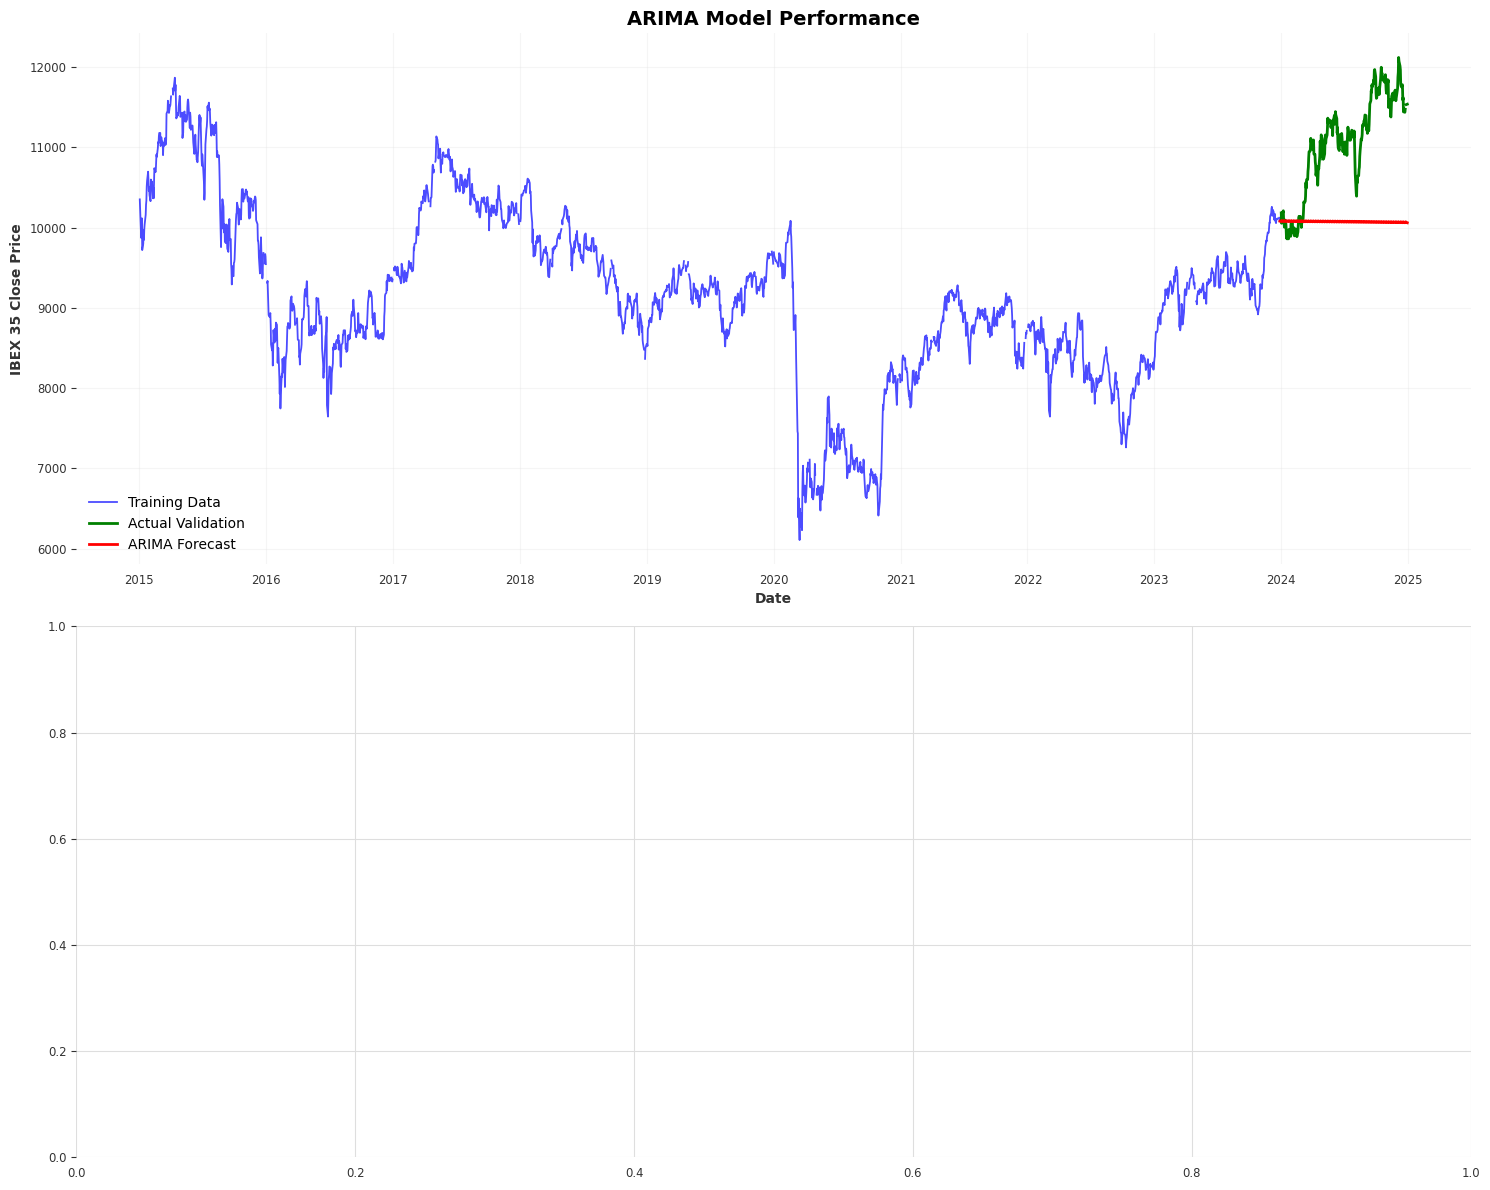

RESUMEN FINAL

Comparación final de modelos:
----------------------------------------
Modelo MAPE (%) SMAPE (%)    MAE      R²    RMSE
 ARIMA     8.75      9.28 995.41 -2.4840 1147.50


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ARIMA, Prophet
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, smape, mae, r2_score, rmse
import warnings
warnings.filterwarnings('ignore')

# mismo timeseries pero sin covariables
darts_series = TimeSeries.from_dataframe(
    dataset,
    time_col="Date",
    value_cols=["ibex_close"],
    freq='B',
    fill_missing_dates=False
)

train_series, val_series = darts_series.split_before(0.9)

scaler_target = Scaler()
train_target_scaled = train_series
val_target_scaled = val_series

print(f"Train series length: {len(train_target_scaled)}")
print(f"Validation series length: {len(val_target_scaled)}")

try:
    model.fit(train_series)

    forecast = model.predict(len(val_series))

    mape_val = mape(val_series, forecast)
    smape_val = smape(val_series, forecast)
    mae_val = mae(val_series, forecast)
    r2_val = r2_score(val_series, forecast)
    rmse_val = rmse(val_series, forecast)

    print(f"\nMétricas para {model_name}:")
    print(f"MAPE: {mape_val:.4f}")
    print(f"SMAPE: {smape_val:.4f}")
    print(f"MAE: {mae_val:.4f}")
    print(f"R² Score: {r2_val:.4f}")
    print(f"RMSE: {rmse_val:.4f}")

except Exception as e:
    return None


arima_model = ARIMA(
    p=1,
    d=1,
    q=1,
    seasonal_order=(1, 1, 1, 5)
)

train_unscaled = train_target_scaled
val_unscaled = val_target_scaled
arima_forecast_unscaled = arima_results['forecast']

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

axes[0].plot(train_unscaled.time_index, train_unscaled.values(),
              label='Training Data', color='blue', alpha=0.7)
axes[0].plot(val_unscaled.time_index, val_unscaled.values(),
              label='Actual Validation', color='green', linewidth=2)
axes[0].plot(arima_forecast_unscaled.time_index, arima_forecast_unscaled.values(),
              label='ARIMA Forecast', color='red', linewidth=2)
axes[0].set_title('ARIMA Model Performance', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('IBEX 35 Close Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Prophet
prophet_model = Prophet()
prophet_model.fit(train_series)

prophet_forecast = prophet_model.predict(len(val_series))

mape_val = mape(val_series, prophet_forecast)
smape_val = smape(val_series, prophet_forecast)
mae_val = mae(val_series, prophet_forecast)
r2_val = r2_score(val_series, prophet_forecast)
rmse_val = rmse(val_series, prophet_forecast)

print(f"\nMétricas para {model_name}:")
print(f"MAPE: {mape_val:.4f}")
print(f"SMAPE: {smape_val:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"R² Score: {r2_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")


fig, axes = plt.subplots(2, 1, figsize=(15, 12))

axes[1].plot(train_series.time_index, train_series.values(),
              label='Training Data', color='blue', alpha=0.7)
axes[1].plot(val_series.time_index, val_series.values(),
              label='Actual Validation', color='green', linewidth=2)
axes[1].plot(prophet_results['forecast'].time_index, prophet_results['forecast'].values(),
              label='Prophet Forecast', color='orange', linewidth=2)
axes[1].set_title('Prophet Model Performance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('IBEX 35 Close Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:
from darts.models.forecasting.rnn_model import RNNModel
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# Configurar callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=20,
    verbose=1,
    mode="min"
)

lr_logger = LearningRateMonitor(logging_interval="epoch")

input_chunk_length = 13
output_chunk_length = 1
hidden_dim = 32
n_epochs = 100
batch_size = 1024

# Instantiate RNNModel as LSTM
lstm_model = RNNModel(
    model="LSTM",
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_dim=hidden_dim,
    n_epochs=n_epochs,
    batch_size=batch_size
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [early_stop_callback, lr_logger], "logger": True},
    optimizer_kwargs={"lr": 0.00085}
)

lstm_model.fit(
    series=train_target,
    future_covariates=train_future_cov,
    val_series=val_target,
    val_future_covariates=val_future_cov,
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | eval 
1 | train_criterion | MSELoss          | 0      | eval 
2 | val_criterion   | MSELoss          | 0      | eval 
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 9.7 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
9.8 K     Trainable params
0         Non-trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.506


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 2.481


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 2.458


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 2.436


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 2.413


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 2.392


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 2.373


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 2.355


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 2.335


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 2.315


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 2.294


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 2.268


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 2.236


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 2.194


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.058 >= min_delta = 0.001. New best score: 2.136


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.080 >= min_delta = 0.001. New best score: 2.056


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.104 >= min_delta = 0.001. New best score: 1.952


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.131 >= min_delta = 0.001. New best score: 1.821


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.143 >= min_delta = 0.001. New best score: 1.678


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.139 >= min_delta = 0.001. New best score: 1.538


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.124 >= min_delta = 0.001. New best score: 1.415


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.104 >= min_delta = 0.001. New best score: 1.310


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.079 >= min_delta = 0.001. New best score: 1.231


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.062 >= min_delta = 0.001. New best score: 1.169


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.001. New best score: 1.118


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 1.072


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.001. New best score: 1.026


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.001. New best score: 0.976


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.001. New best score: 0.925


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.001. New best score: 0.874


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 0.827


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.787


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 0.753


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.725


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.703


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.681


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.661


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.641


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.621


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.597


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.572


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.552


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.535


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.517


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.500


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.485


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.472


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.459


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.447


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.434


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.425


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.418


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.412


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.404


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.396


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.388


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.382


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.377


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.375


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.370


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.364


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.360


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.357


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.355


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.351


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.345


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.341


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.338


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.334


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.330


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.326


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.321


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.318


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.316


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.313


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.310


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.307


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.303


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.299


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.295


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.293


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.292


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.290


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.285


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.277


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.272


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.269


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.267


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.264


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.262


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.260


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.257


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.255


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.252


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.248


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.245


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.243


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=13, output_chunk_length=1, n_epochs=100, batch_size=1024, random_state=42, force_reset=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x78869649b510>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x7886d21a3110>], 'logger': True}, optimizer_kwargs={'lr': 0.00085})

In [ ]:
from darts.metrics import mape, smape, mae, r2_score, rmse

# Generate historical forecasts on the validation set
forecast = lstm_model.historical_forecasts(
    series=val_target,
    future_covariates=val_future_cov,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True
)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


LSTM Model Metrics on Validation Set:
MAPE: 17.3853
SMAPE: 19.2812
MAE: 0.3009
R² Score: 0.5209
RMSE: 0.3444


In [ ]:
scaler = RobustScaler()
scaler = Scaler(scaler)
scaler_target = scaler.fit(train_series['ibex_close'])

forecast_unscaled = scaler_target.inverse_transform(forecast)
val_target_unscaled = scaler_target.inverse_transform(val_target)

# Calculate error metrics
mape_val = mape(val_target_unscaled, forecast_unscaled)
smape_val = smape(val_target_unscaled, forecast_unscaled)
mae_val = mae(val_target_unscaled, forecast_unscaled)
r2_val = r2_score(val_target_unscaled, forecast_unscaled)
rmse_val = rmse(val_target_unscaled, forecast_unscaled)

print("\nLSTM Model Metrics on Validation Set:")
print(f"MAPE: {mape_val:.4f}")
print(f"SMAPE: {smape_val:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"R² Score: {r2_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")


LSTM Model Metrics on Validation Set:
MAPE: 3.1318
SMAPE: 3.1953
MAE: 355.3568
R² Score: 0.5209
RMSE: 406.6652


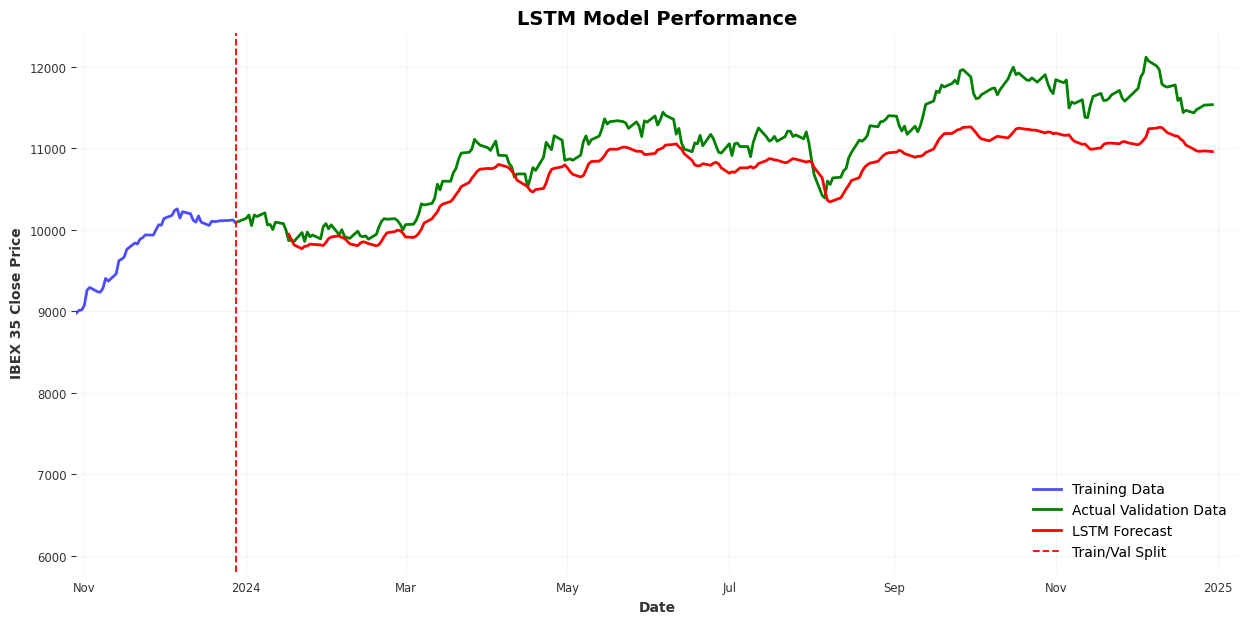

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

train_target_unscaled =  scaler_target.inverse_transform(train['ibex_close'])
train_target_unscaled.plot(label='Training Data', color='blue', alpha=0.7)
plt.xlim([train.end_time() - pd.Timedelta(days=60), val.end_time() + pd.Timedelta(days=10)])

val_target_unscaled.plot(label='Actual Validation Data', color='green', linewidth=2)
forecast_unscaled.plot(label='LSTM Forecast', color='red', linewidth=2)

plt.axvline(x=train_target.end_time(), color='red', linestyle='--', label='Train/Val Split')

plt.title('LSTM Model Performance', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('IBEX 35 Close Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()